## Assignment 1 - Bayesian Analysis on a Grid
Christopher Monaghan

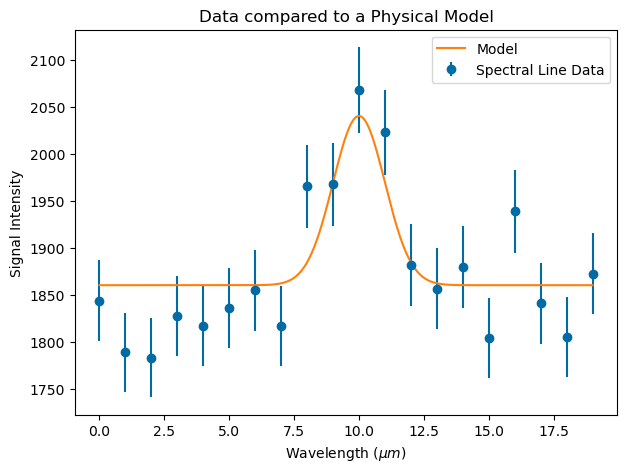

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import tqdm

plt.style.use('tableau-colorblind10')

#We'll define a function for our Gaussian below, using the equation provided in the assignment 1 pdf
#p should take the form as a 2D array [A,B]
#0 <= A <= 1000, 0 <= B <=3000
def Gaussian(x: np.ndarray[float], p: np.ndarray[float], x0: float = 10.0, omega: float = 1.0) -> np.ndarray[float]: #the width (omega) and mean (x0) are known and set to default values
    A, B = p #extract the A and B values from the p argument
    return A * np.exp(-(x-x0)**2/(2*omega**2))+B #return 'y'


x_data, y_data = np.loadtxt('data.txt', unpack=True) #load in the values from data.txt


p_default = [180, 1860]
#Generate the model data using the values A = 180, B = 1860
x_model = np.linspace(min(x_data), max(x_data), 1000) #Well-sampled x axis with 1000 points
y_model = Gaussian(x_model, p_default) #Generate the gaussian using the model defined above

#Time to plot!
plt.figure(figsize = (7,5))
#plt.errorbar allows us to plot the spectral line data with the y error bars
#the error in this canse is the square root of the observed data
plt.errorbar(x_data, y_data, yerr = np.sqrt(y_data), fmt = 'o', label='Spectral Line Data') 
plt.plot(x_model, y_model, label='Model')
plt.xlabel("Wavelength ($\mu m$)") #no actual units for either axis are given, so I'm assuming microns (infrared spectroscopy <3)
plt.ylabel("Signal Intensity") #unitless for now
plt.legend()
plt.title("Data compared to a Physical Model")
plt.show()


In [3]:
def prior_uniform(p: np.ndarray[float], a_bounds: np.ndarray[float] = [0, 1000], b_bounds: np.ndarray[float] = [0, 3000]) -> np.ndarray[float]:
    A, B = p #extract the A and B values from the p argument
    A_min, A_max = a_bounds
    B_min, B_max = b_bounds
    return (np.where(np.logical_and(A >= A_min, A <= A_max), 1/(A_max-A_min), 0) * 
            np.where(np.logical_and(B >= B_min, B <= B_max), 1/(B_max-B_min), 0))

print('Prior probability for [A, B] = ' + str(p_default) + ': ' + str(prior_uniform(p_default)))
    

Prior probability for [A, B] = [180, 1860]: 3.3333333333333335e-07


In [4]:
def likelihood_gaussian(x: np.ndarray[float], y: np.ndarray[float], p: np.ndarray[float], y_err: np.ndarray[float]) -> np.ndarray[float]: 
    
    likelihood_prob = 1
    
    #The Gaussian likelihood function uses equation 2.14 from the textbook
    #We take sigma as the error for each data point (np.sqrt(y_data[k]) = y_err[k])
    #and mu as the as the ideal data point (calculated using the Gaussian function at x[k])
    
    for k in range(len(x)):
        prob_k = (1 / (y_err[k] * np.sqrt(2 * np.pi)) * 
                  np.exp(-(y[k] - Gaussian(x[k], p))**2/(2 * y_err[k]**2)))
        
        #because we have set of independent data, we must multiply all individual data likelihoods together
        
        likelihood_prob = likelihood_prob * prob_k
    
        #print(prob_k / (1/(y_err[k] * np.sqrt(2 * np.pi)))) 
    
    return likelihood_prob #Will be pretty small!

print('Likelihood for [A, B] = ' + str(p_default) + ': ' + str(likelihood_gaussian(x_data, y_data, p_default, np.sqrt(y_data))))


Likelihood for [A, B] = [180, 1860]: 3.888378992616983e-46


In [5]:
def posterior(x: np.ndarray[float], y: np.ndarray[float], p: np.ndarray[float], y_err: np.ndarray[float]) -> np.ndarray[float]: 
    posterior_prob = likelihood_gaussian(x, y, p, y_err) * prior_uniform(p)
    return posterior_prob

print('Posterior for [A, B] = ' + str(p_default) + ': ' + str(posterior(x_data, y_data, p_default, np.sqrt(y_data))))

Posterior for [A, B] = [180, 1860]: 1.2961263308723278e-52


100%|██████████| 300/300 [00:09<00:00, 31.60it/s]


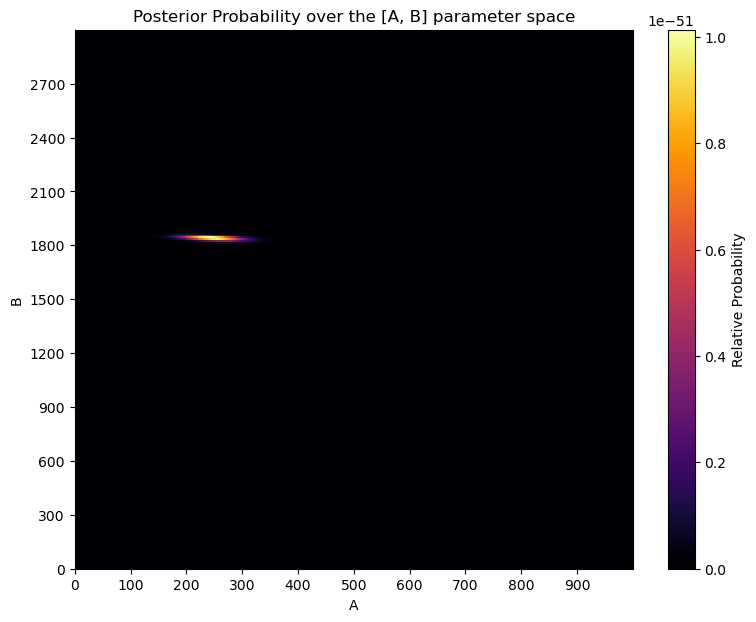

In [34]:
A_grid = np.linspace(0, 1000, 300)
B_grid = np.linspace(0, 3000, 300)

posterior_grid = np.zeros((300,300), dtype=float)

for j in tqdm.tqdm(range(len(B_grid))):
    for i in range(len(A_grid)):
        posterior_grid[j][i] = posterior(x_data, y_data, [A_grid[i],B_grid[j]], np.sqrt(y_data))

plt.figure(figsize = (9,7))
plt.pcolormesh(posterior_grid, cmap = 'inferno')
plt.xlabel("A") 
plt.xticks(np.arange(0,300,30), labels=np.arange(0,1000,100))
plt.ylabel("B")
plt.yticks(np.arange(0,300,30), labels=np.arange(0,3000,300))
plt.title("Posterior Probability over the [A, B] parameter space")
plt.colorbar(label = 'Relative Probability')
plt.show()

100%|██████████| 300/300 [00:09<00:00, 31.73it/s]


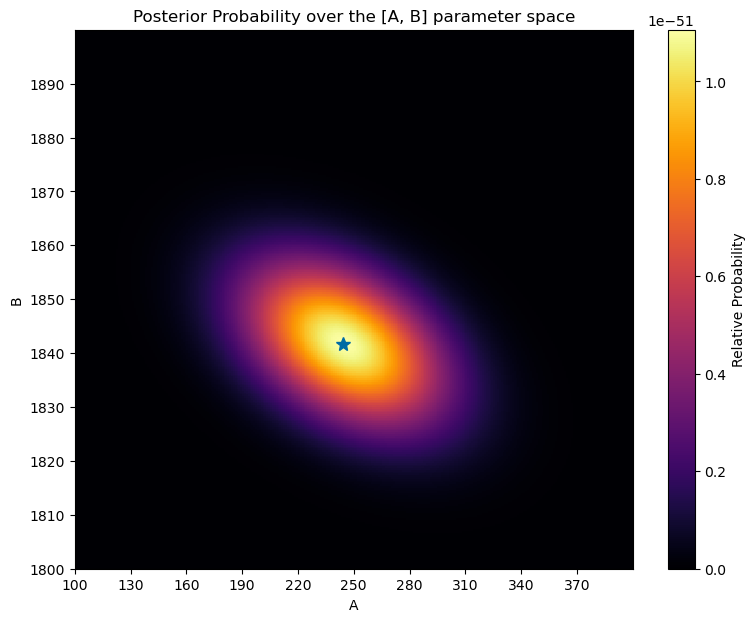

Maximum probability occurs at [A, B] = [244.48160535117057, 1841.8060200668897]


In [35]:
A_grid_small = np.linspace(100, 400, 300)
B_grid_small = np.linspace(1800, 1900, 300)

posterior_grid_small = np.zeros((300,300), dtype=float)

for j in tqdm.tqdm(range(len(B_grid_small))):
    for i in range(len(A_grid_small)):
        posterior_grid_small[j][i] = posterior(x_data, y_data, [A_grid_small[i],B_grid_small[j]], np.sqrt(y_data))

max_prob_coords = np.unravel_index(posterior_grid_small.argmax(), posterior_grid_small.shape)
B_best = B_grid_small[max_prob_coords[0]]
A_best = A_grid_small[max_prob_coords[1]]
max_prob_values = [A_best, B_best]

plt.figure(figsize = (9,7))
plt.pcolormesh(posterior_grid_small, cmap = 'inferno')
plt.plot(max_prob_coords[1], max_prob_coords[0], '*', ms=10)
plt.xlabel("A") 
plt.xticks(np.arange(0,300,30), labels=np.arange(100, 400, 30))
plt.ylabel("B")
plt.yticks(np.arange(0,300,30), labels=np.arange(1800, 1900, 10))
plt.title("Posterior Probability over the [A, B] parameter space")
plt.colorbar(label = 'Relative Probability')
plt.show()

print('Maximum probability occurs at [A, B] = ' + str(max_prob_values))

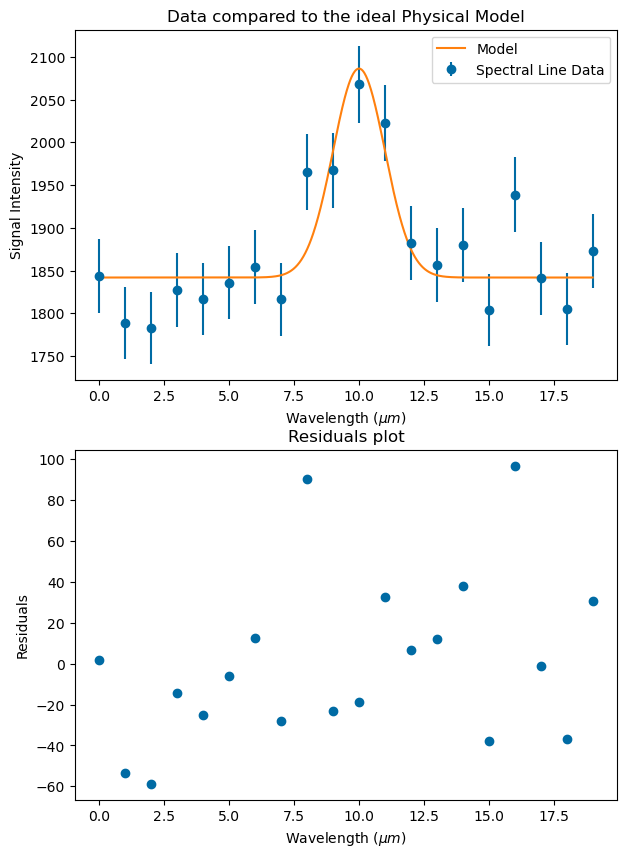

In [36]:
fig, ax = plt.subplots(2,1)
fig.set_figheight(10)
fig.set_figwidth(7)
#plt.errorbar allows us to plot the spectral line data with the y error bars
#the error in this canse is the square root of the observed data

x_model = np.linspace(min(x_data), max(x_data), 1000) #Well-sampled x axis with 1000 points
y_model = Gaussian(x_model, max_prob_values) #Generate the gaussian using the model defined above

ax[0].errorbar(x_data, y_data, yerr = np.sqrt(y_data), fmt = 'o', label='Spectral Line Data') 
ax[0].plot(x_model, y_model, label='Model')
ax[0].set_xlabel("Wavelength ($\mu m$)") 
ax[0].set_ylabel("Signal Intensity") #unitless for now
ax[0].legend()
ax[0].set_title("Data compared to the ideal Physical Model")

y_model_lowres = Gaussian(x_data, max_prob_values) #Generate the gaussian using the model defined above
residuals = (y_data - y_model_lowres) #residual = actual - predicted/ideal

ax[1].scatter(x_data, residuals)
ax[1].set_xlabel("Wavelength ($\mu m$)")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Residuals plot")

plt.show()

In [38]:
#The Bayesian evidence can be calculated by integrating the probabilities over the entire parameter space

Bayesian_evidence = np.sum(posterior_grid)
print('Bayesian evidence for 3a) =', Bayesian_evidence)

Bayesian_evidence_small = np.sum(posterior_grid_small)
print('Bayesian evidence for 3c) =', Bayesian_evidence_small)
#The way it's calculated shows the two as different as we're ignoring the different binsizes. 
#In actuality, the bayesian evidence for both grids should be the same when accounting for the 
#binsize of each grid.

#The binsizes cancel out with our summation method, thus we do not include it.

#EXPLAIN THIS IN MORE DETAIL IN THE WRITEUP :)!!!!

#We'll normalize the grids by dividing each by the Bayesian evidence
posterior_grid_normalized = posterior_grid/np.sum(posterior_grid)
posterior_grid_small_normalized = posterior_grid_small/np.sum(posterior_grid_small)

#As a sanity check, we could print the integral over the normalized posterior grids and see that they're equal to one
print(np.sum(posterior_grid_normalized))
print(np.sum(posterior_grid_small_normalized))


Bayesian evidence for 3a) = 7.430433295123557e-50
Bayesian evidence for 3c) = 7.429721129033133e-48
0.9999999999999999
1.0
